To perform registration with `DiffDRR`, we do the following:

1. Obtain a target X-ray (this is the image whose pose parameters we wish to recovery)
2. Initialize a moving DRR module from a random camera pose
3. Measure the loss between the target X-ray and the moving DRR (we use normalized negative cross-correlation)
4. Backpropogate this loss the parameters of the moving DRR and render from the new parameters
5. Repeat Steps 3-4 until the loss has converged

## 1. Generate a target X-ray

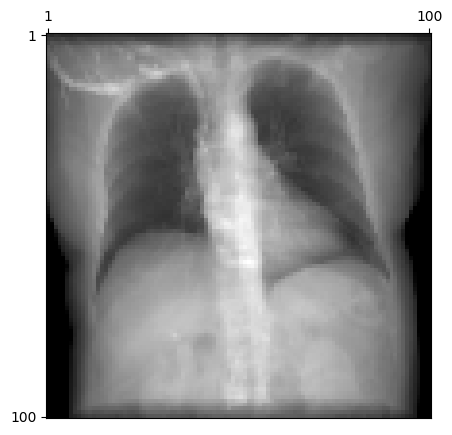

In [ ]:
#| code-fold: true
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.metrics import (
    MultiscaleNormalizedCrossCorrelation2d,
    NormalizedCrossCorrelation2d,
)
from diffdrr.visualization import plot_drr

# Make the ground truth X-ray
SDD = 1020.0
HEIGHT = 100
DELX = 4.0

subject = load_example_ct()
true_params = {
    "sdr": SDD,
    "alpha": 0.0,
    "beta": 0.0,
    "gamma": 0.0,
    "bx": 0.0,
    "by": 850.0,
    "bz": 0.0,
}
device = "cuda" if torch.cuda.is_available() else "cpu"

drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
rotations = torch.tensor(
    [
        [
            true_params["alpha"],
            true_params["beta"],
            true_params["gamma"],
        ]
    ]
).to(device)
translations = torch.tensor(
    [
        [
            true_params["bx"],
            true_params["by"],
            true_params["bz"],
        ]
    ]
).to(device)
ground_truth = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZXY",
)

plot_drr(ground_truth)
plt.show()

## 2. Initialize a moving DRR from a random pose

In [ ]:
from diffdrr.pose import convert


def pose_from_carm(sid, tx, ty, alpha, beta, gamma):
    R = convert(
        torch.tensor([[alpha, beta, gamma]]),
        torch.tensor([[0.0, 0.0, 0.0]]),
        parameterization="euler_angles",
        convention="ZXY",
    )
    t = convert(
        torch.tensor([[0.0, 0.0, 0.0]]),
        torch.tensor([[tx, sid, ty]]),
        parameterization="euler_angles",
        convention="ZXY",
    )
    return t.compose(R)

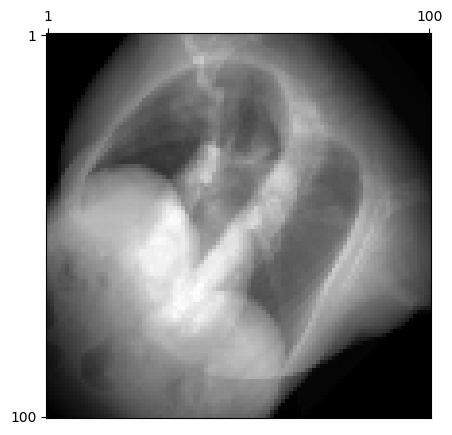

(tensor([[-0.5823,  0.7765, -0.6142]], device='cuda:0'),
 tensor([[ 25.1167, 849.3047,   6.7046]], device='cuda:0'))

In [ ]:
#| code-fold: true
# Make a random DRR
np.random.seed(5)


def get_initial_parameters(true_params):
    alpha = true_params["alpha"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    beta = true_params["beta"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    gamma = true_params["gamma"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    bx = true_params["bx"] + np.random.uniform(-30.0, 30.0)
    by = true_params["by"] + np.random.uniform(-30.0, 30.0)
    bz = true_params["bz"] + np.random.uniform(-30.0, 30.0)
    pose = pose_from_carm(by, bx, bz, alpha, beta, gamma).cuda()
    # rotations, translations = pose.convert("euler_angles", "ZXY")
    rotations = torch.tensor([[alpha, beta, gamma]], device=device)
    translations = torch.tensor([[bx, by, bz]], device=device)
    return rotations, translations, pose


rotations, translations, pose = get_initial_parameters(true_params)
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
with torch.no_grad():
    est = drr(pose)
plot_drr(est)
plt.show()

rotations, translations

## 3. Measure the loss between the target X-ray and moving DRR

We start by measuring the initial loss between the two images.

In [ ]:
criterion = NormalizedCrossCorrelation2d()
criterion(ground_truth, est).item()

0.3980734050273895

If the negative normalized cross-correlation is greater than 0.999, we say the target and moving DRR have converged.

## 4. Backpropogate the loss to the moving DRR parameters

We also use this example to show how different optimizers affect the outcome of registration.
The parameters we tweak are

- `lr_rotations`: learning rate for rotation parameters
- `lr_translations`: learning rate for translation parameters
- `momentum`: momentum for stochastic gradient descent
- `dampening`: dampening for stochastic gradient descent

In [ ]:
from torch import nn


class Registration(nn.Module):
    """Perform automatic 2D-to-3D registration using differentiable rendering."""

    def __init__(
        self,
        drr: DRR,
        rotation: torch.Tensor,
        translation: torch.Tensor,
        parameterization: str,
        convention: str = None,
    ):
        super().__init__()
        self.drr = drr
        self._rotation = nn.Parameter(rotation)
        self._translation = nn.Parameter(translation)
        self.parameterization = parameterization
        self.convention = convention

    def forward(self):
        return self.drr(self.pose)

    @property
    def pose(self):
        R = convert(
            self._rotation,
            torch.tensor([[0.0, 0.0, 0.0]]).to(self._rotation),
            parameterization=self.parameterization,
            convention=self.convention,
        )
        t = convert(
            torch.tensor([[0.0, 0.0, 0.0]]).to(self._translation),
            self._translation,
            parameterization=self.parameterization,
            convention=self.convention,
        )
        return t.compose(R)

    @property
    def rotation(self):
        return (
            self.pose.convert(self.parameterization, self.convention)[0]
            .clone()
            .detach()
            .cpu()
        )

    @property
    def translation(self):
        return (
            self.pose.convert(self.parameterization, self.convention)[1]
            .clone()
            .detach()
            .cpu()
        )

In [ ]:
def optimize(
    reg: Registration,
    ground_truth,
    lr_rotations=1e-1,
    lr_translations=1e2,
    momentum=0,
    dampening=0,
    n_itrs=250,
    optimizer="sgd",  # 'sgd' or `adam`
):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(
            [
                {"params": [reg._rotation], "lr": lr_rotations},
                {"params": [reg._translation], "lr": lr_translations},
            ],
            momentum=momentum,
            dampening=dampening,
            maximize=True,
        )
    else:
        optimizer = torch.optim.Adam(
            [
                {"params": [reg._rotation], "lr": lr_rotations},
                {"params": [reg._translation], "lr": lr_translations},
            ],
            maximize=True,
        )

    params = []
    losses = []
    for itr in tqdm(range(n_itrs), ncols=50):
        # Save the current set of parameters
        alpha, beta, gamma = reg.rotation.squeeze().tolist()
        bx, by, bz = reg.translation.squeeze().tolist()
        params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

        # Run the optimization loop
        optimizer.zero_grad()
        estimate = reg()
        loss = criterion(ground_truth, estimate)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())

        if loss > 0.99:
            tqdm.write(f"Converged in {itr} iterations")
            break

    plot_drr(
        torch.concat([ground_truth, estimate, ground_truth - estimate]),
        title=f"{loss.item()}",
    )
    plt.show()
    df = pd.DataFrame(params, columns=["alpha", "beta", "gamma", "bx", "by", "bz"])
    df["loss"] = losses
    return df

## Run the optimization algorithm

 74%|████████▏  | 185/250 [00:05<00:01, 35.45it/s]


Converged in 185 iterations


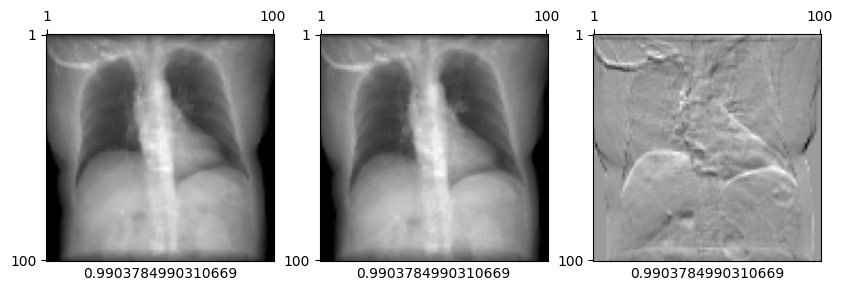

0.9903784990310669


 56%|██████▏    | 141/250 [00:03<00:03, 35.75it/s]


Converged in 141 iterations


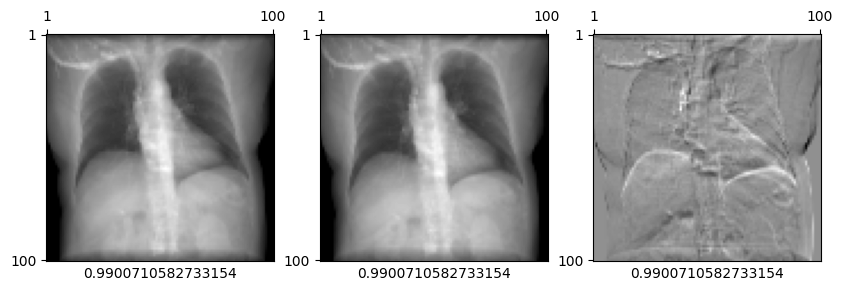

 42%|████▌      | 104/250 [00:02<00:04, 35.78it/s]


Converged in 104 iterations


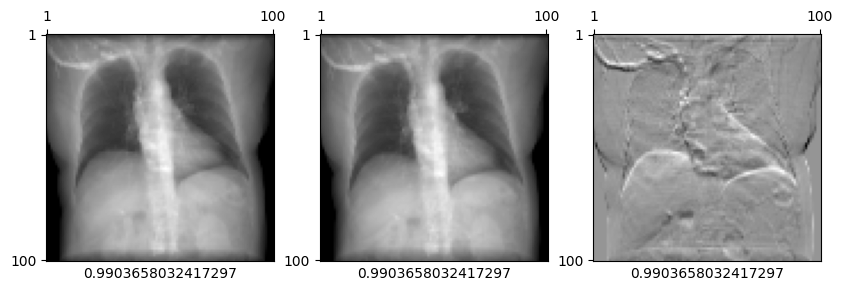

 15%|█▊          | 38/250 [00:01<00:05, 35.71it/s]


Converged in 38 iterations


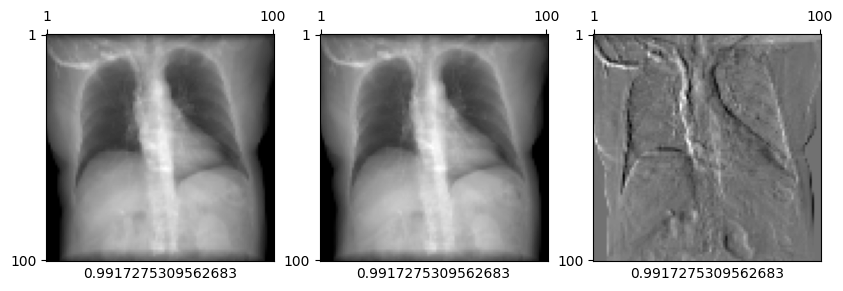

In [ ]:
# Base SGD
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_base = optimize(
    reg,
    ground_truth,
    lr_rotations=5e-2,
)
print(params_base["loss"].iloc[-1])
del drr

# SGD + momentum
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_momentum = optimize(reg, ground_truth, momentum=9e-2)
del drr

# SGD + momentum + dampening
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_momentum_dampen = optimize(reg, ground_truth, momentum=9e-2, dampening=0.1)
del drr

# Adam
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZXY",
)
params_adam = optimize(reg, ground_truth, 1e-1, 1e1, optimizer="adam")
del drr

## Visualize the parameter updates

Note that differences that between different optimization algorithms can be seen in the motion in the DRRs!

In [ ]:
#| code-fold: true
from base64 import b64encode

from IPython.display import HTML, display

from diffdrr.visualization import animate


def animate_in_browser(df):
    n = MAX_LENGTH - len(df)
    df = pd.concat([df, df.iloc[[-1] * n]])

    out = animate(
        "<bytes>",
        df,
        drr,
        ground_truth=ground_truth,
        verbose=True,
        device=device,
        extension=".webp",
        duration=30,
        parameterization="euler_angles",
        convention="ZXY",
    )
    display(HTML(f"""<img src='{"data:img/gif;base64," + b64encode(out).decode()}'>"""))


MAX_LENGTH = max(map(len, [params_base, params_momentum, params_momentum_dampen, params_adam]))
drr = DRR(subject, sdd=SDD, height=HEIGHT, delx=DELX).to(device)

In [ ]:
animate_in_browser(params_base)

Precomputing DRRs: 100%|█████████████████| 186/186 [00:32<00:00,  5.66it/s]


In [ ]:
animate_in_browser(params_momentum)

Precomputing DRRs: 100%|█████████████████| 186/186 [00:32<00:00,  5.66it/s]


In [ ]:
animate_in_browser(params_momentum_dampen)

Precomputing DRRs: 100%|█████████████████| 186/186 [00:33<00:00,  5.57it/s]


In [ ]:
animate_in_browser(params_adam)

Precomputing DRRs: 100%|█████████████████| 186/186 [00:33<00:00,  5.58it/s]
